# Data Collection
This notebook has the code to scrape all of the artists used for this project and their lyrics.

Sources
- Artists: https://www.billboard.com/charts/year-end
- Scraping Lyrics: https://lyricsgenius.readthedocs.io/en/master/index.html

In [4]:
#Keep my access token secret

with open('./token.txt', 'r') as f:
    token = f.read().replace('\n', '')

In [5]:
from lyricsgenius import Genius #Credit: https://lyricsgenius.readthedocs.io/en/master/index.html
import pandas as pd
import numpy as np
import json
import os
import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns

genius = Genius(token, 
                sleep_time = 1, #don't overload the servers
                remove_section_headers=True, #removes [Chorus], [Bridge], etc. headers from lyrics.
                verbose=False) # Do not print out results

# Scrape Billboard Top Artist Categories

In [6]:
#function will scrape past 3 years of top billboard artists for that genre
def get_top_artists(years=['2017','2018','2019'], genre=('folk-artists', 'pop-songs-artists','dance-club-artists')):
    
    #create empty list to store artists
    artists = []
    
    #loop through each year
    for year in years:
    
        #build the url
        url = 'https://www.billboard.com/charts/year-end/'+ year + '/' + genre
        res = requests.get(url)
        soup = BeautifulSoup(res.content, 'lxml')
        
        #scrape the top artists
        for row in soup.find_all('div', attrs={'class': 'ye-chart-item__title'}):
            artists.append((row.find('a').text).replace('\n','').strip()) #remove extra spaces and new line chars
            
    return list(set(artists)) #only return unique values

In [7]:
folk_artists = get_top_artists(genre='folk-artists')
folk_artists

['James Taylor',
 'Ed Sheeran',
 'The Lumineers',
 'Jack Johnson',
 'John Mayer',
 'Chris Stapleton',
 'Hozier',
 'Neil Young',
 'Lord Huron',
 'Mumford & Sons',
 'Kacey Musgraves',
 'KALEO',
 'Tyler Childers',
 'Vance Joy',
 'Simon & Garfunkel',
 'Leon Bridges']

In [8]:
pop_artists = get_top_artists(genre='pop-songs-artists')
pop_artists

['Bruno Mars',
 'Khalid',
 'Shawn Mendes',
 'Niall Horan',
 'Jonas Brothers',
 'Charlie Puth',
 'Lizzo',
 'Drake',
 'Imagine Dragons',
 'Dua Lipa',
 'Post Malone',
 'Halsey',
 'Maroon 5',
 'The Chainsmokers',
 'Billie Eilish',
 'Alessia Cara',
 'NF',
 'Ed Sheeran',
 'Ariana Grande',
 'Panic! At The Disco',
 'Camila Cabello',
 'Selena Gomez']

In [9]:
dance_artists = get_top_artists(genre='dance-club-artists')
dance_artists

['Bruno Mars',
 'Dirty Werk',
 'Kristine W',
 'Sia',
 'Diana Ross',
 'Barbara Tucker',
 'Ono',
 'DJs From Mars',
 'Mark Ronson',
 'Tony Moran',
 'Bebe Rexha',
 'Sam Smith',
 'Rita Ora',
 'Toni Braxton',
 'Donna Summer',
 'Niall Horan',
 'Dave Aude',
 'Ava Max',
 'Axwell & Ingrosso',
 'Skylar Stecker',
 'VASSY',
 'DNCE',
 'Sabrina Carpenter',
 'Clean Bandit',
 'Bleona',
 'Todd Edwards',
 'Troye Sivan',
 'R3HAB',
 'Jonas Blue',
 'DJ Snake',
 'Dua Lipa',
 'Halsey',
 'Demi Lovato',
 'Jack Back',
 'Gryffin',
 'Calvin Harris',
 'Ed Sheeran',
 'Blondie',
 'Madonna',
 'Kendra Erika',
 'Kelly Clarkson',
 'Marshmello',
 'Miley Cyrus',
 'Gorgon City',
 'FISHER',
 'Deborah Cox',
 'Roberto Surace',
 'Rihanna',
 'Fatboy Slim',
 'Sting',
 'Ariana Grande',
 'David Guetta',
 'Alesso',
 'LeAnn Rimes',
 'Katy Perry',
 'Austin Mahone',
 'U2',
 'J Sutta',
 'Dido',
 'Hilary Roberts',
 'P!nk',
 'Lisa Williams']

In [10]:
### Store to be used in another notebook
%store folk_artists
%store pop_artists
%store dance_artists

Stored 'folk_artists' (list)
Stored 'pop_artists' (list)
Stored 'dance_artists' (list)


# Scrape Lyrics from Multiple Artists

In [11]:
#Function to scrape lyrics from the Genius API

def scrape_lyrics(artist_list):
    
    for artist in artist_list:
        artist_lyrics = genius.search_artist(artist, max_songs=2) #grab all of the lyrics from an artist 
        
        #save the output as a json file
        genius.save_artists(artists=[artist_lyrics], overwrite=True)
        
    return None
                            

In [31]:
#scrape all lyrics for top folk_artists from 2017-2019
scrape_lyrics(folk_artists)

In [44]:
#scrape all lyrics for top pop-songs-artists from 2017-2019
scrape_lyrics(pop_artists)

# Function to Create Lyrics Dataframe for each artist

In [12]:
def get_lyrics(filename):
    
    # Reading the json as a dict
    with open(filename) as json_data:
        data = json.load(json_data)

    #Source credit: https://stackoverflow.com/questions/28373282/how-to-read-a-json-dictionary-type-file-with-pandas
    
    #need to account for that every song doesn't have a spotify url
    spotify_url = []
    for song in range(0,len(data['songs'])): #for each song
        if len(data['songs'][song]['media']) > 0: #are there any values in media?

            #store a list of providers to later check if spotify is in that list
            contains_spotify = [data['songs'][song]['media'][item]['provider'] for item in range(0,len(data['songs'][song]['media']))] 

            if 'spotify' in contains_spotify: 
                for item in range(0,len(data['songs'][song]['media'])):  #loop through each item
                    if (data['songs'][song]['media'][item]['provider'] == 'spotify'): #find the item that is spotify
                        spotify_url.append(data['songs'][song]['media'][item]['url']) #add the url 
            else:
                spotify_url.append('NA')
        else:
            spotify_url.append('NA')
    
    #create a dataframe
    df =  pd.DataFrame({

        #multiply by length of songs in json response to create a new row for each
        'artist_name' : [data['name']] * len(data['songs']),                                              #artist name
        'image_url' : [data['image_url']] * len(data['songs']),                                           #thumbnail image
        'url' : [data['url']] * len(data['songs']),                                                       #genius url

        #song data
        'title' : [data['songs'][item]['title'] for item in range(0,len(data['songs']))],                 #title of each song
        'lyrics' : [data['songs'][item]['lyrics'] for item in range(0,len(data['songs']))],                #song lyrics           
        'spotify_url' :  spotify_url, #spotify url


    })
    return df    

# Stack each artist Dataframe into one Dataframe

In [13]:
#create a list of the lyrics json files to be created as dataframes
lyrics_files = ['./lyrics_json/' + filename for filename in os.listdir('./lyrics_json/') if filename.startswith('Lyrics_')]

#create a dataframe for each file and stack them into one dataframe
all_songs_df = pd.concat([get_lyrics(file) for file in lyrics_files])

all_songs_df.head()

,artist_name,image_url,url,title,lyrics,spotify_url
0,Selena Gomez,https://images.genius.com/902d3ed593ed6f5e70ef...,https://genius.com/artists/Selena-gomez,Lose You To Love Me,You promised the world and I fell for it\nI pu...,https://open.spotify.com/track/1HfMVBKM75vxSfs...
1,Selena Gomez,https://images.genius.com/902d3ed593ed6f5e70ef...,https://genius.com/artists/Selena-gomez,Back to You,Took you like a shot\nThought that I could cha...,https://open.spotify.com/track/514rhnksEwHUh6L...
2,Selena Gomez,https://images.genius.com/902d3ed593ed6f5e70ef...,https://genius.com/artists/Selena-gomez,Fetish,Take it or leave it\nBaby take it or leave it\...,https://open.spotify.com/track/4lnAN2S1fcI0Sjx...
3,Selena Gomez,https://images.genius.com/902d3ed593ed6f5e70ef...,https://genius.com/artists/Selena-gomez,Bad Liar,I was walking down the street the other day\nT...,https://open.spotify.com/track/2fZQIJew3nkNe99...
4,Selena Gomez,https://images.genius.com/902d3ed593ed6f5e70ef...,https://genius.com/artists/Selena-gomez,Look At Her Now,Yeah\n\nThey fell in love one summer\nA little...,NA


### Remove "Live Songs" and "Covers" From The Dataframe

Live songs are a sign of duplicates and Covers belong to another artist.

In [14]:
# Remove songs that were performed live
all_songs = all_songs_df[~all_songs_df['title'].str.contains('Live in|Live at|Live from|\(*Live*\)|\(*Cover*\)',case=False, regex=True)]

### Add a column `billboard_genre`

In [15]:
folk_artists.remove('Ed Sheeran') #Ed Sheeran is in both lists and will be "Pop" for this use case

In [16]:
# create a list of our conditions
conditions = [
    (all_songs['artist_name'].str.contains('|'.join(folk_artists),case=False, regex=True)),
    (all_songs['artist_name'].str.contains('|'.join(pop_artists),case=False, regex=True)) 
    ]

# create a list of the values we want to assign for each condition
values = ['folk_americana', 'pop']

# create a new column and use np.select to assign values to it using our lists as arguments
all_songs['billboard_genre'] = np.select(conditions, values)

#adapted from https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/ 

/Users/joshuamizraji/anaconda3/envs/personal/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


### Check Spotify URLs

In [17]:
#view how many songs don't have a spotify url
no_spotify_ct = all_songs[all_songs['spotify_url'] == 'NA'].shape[0]
yes_spotify_ct = all_songs[all_songs['spotify_url'] != 'NA'].shape[0]
print(f'Songs without Spotify URL: {no_spotify_ct}')
print(f'Songs with Spotify URL: {yes_spotify_ct}')
print(f'Percentage without Spotify URL: {round(no_spotify_ct / (all_songs.shape[0]),3)}')
print(f'Percentage with Spotify URL: {round(yes_spotify_ct / (all_songs.shape[0]),3)}')

Songs without Spotify URL: 4099
Songs with Spotify URL: 1113
Percentage without Spotify URL: 0.786
Percentage with Spotify URL: 0.214


### Check for null values

In [47]:
all_songs.isnull().sum()

artist_name        0
image_url          0
url                0
title              0
lyrics             0
spotify_url        0
billboard_genre    0
dtype: int64

#### Check the Value Counts of Each Artist

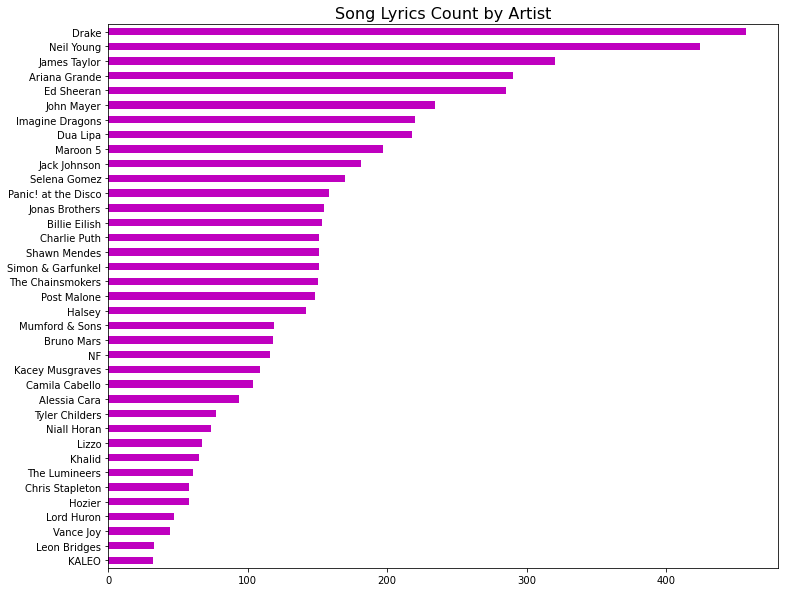

In [46]:
plt.figure(figsize=(12,10))
all_songs_df['artist_name'].value_counts(ascending=True).plot(kind='barh',color='m');
plt.title('Song Lyrics Count by Artist', size=16);
plt.savefig('./imgs/song_lyrics_count.jpeg',bbox_inches='tight');

## Save DataFrame as a csv

In [132]:
#save as a csv
all_songs.to_csv('all_songs.csv', index=False)

# Create a Dataframe with all of the lyrics in one cell by artist

In [24]:
#create a blank dictionary
ly_dict = {}

for artist in all_songs['artist_name'].unique():
    
    ly_dict['artist_name'] = [artist for artist in all_songs['artist_name'].unique()] 
    ly_dict['lyrics'] = [all_songs[all_songs['artist_name'] == artist]['lyrics'].str.cat(sep=' ') for artist in all_songs['artist_name'].unique()]
    ly_dict['billboard_genre'] = [all_songs[all_songs['artist_name'] == artist]['billboard_genre'].values[0] for artist in all_songs['artist_name'].unique()]

all_lyrics = pd.DataFrame(ly_dict)

In [25]:
all_lyrics

,artist_name,lyrics,billboard_genre
0,Selena Gomez,You promised the world and I fell for it\nI pu...,pop
1,​The Lumineers,"Ah, ah, when I was younger\nI, I should've kno...",folk_americana
2,Simon & Garfunkel,"Hello darkness, my old friend\nI've come to ta...",folk_americana
3,Mumford & Sons,Heto mi halanma\nMine waddimi yiddema\nKo ane ...,folk_americana
4,Lord Huron,I am not the only traveler\nWho has not repaid...,folk_americana
5,Billie Eilish,Don't you know I'm no good for you?\nI've lear...,pop
6,Vance Joy,I was scared of dentists and the dark\nI was s...,folk_americana
7,Neil Young,"Old man, look at my life\nI'm a lot like you w...",folk_americana
8,Ariana Grande,Thought I'd end up with Sean\nBut he wasn't a ...,pop
9,Niall Horan,(Woo)\n\nWe should take this back to my place\...,pop


### Save as a CSV

In [34]:
#save as a csv
all_lyrics.to_csv('all_lyrics.csv', index=False)